In [20]:
import pandas as pd
import geopandas as gpd
import xarray as xr
import numpy as np
import json
import glob
import matplotlib.pyplot as plt
import warnings
from oggm import utils

In [2]:
rgi_df = []
for reg in range(1, 20):
    df = gpd.read_file(utils.get_rgi_region_file(f'{reg:02d}', version='62'))
    # For greenland we omit connectivity level 2
    if f'{reg:02d}' == '05':
        df = df.loc[df['Connect'] != 2]
    rgi_df.append(df)
rgi_df = pd.concat(rgi_df)

In [3]:
rgi_df = rgi_df.set_index('RGIId')

In [4]:
# Add Farinotti volume
dfr = pd.read_hdf(utils.get_demo_file('rgi62_itmix_df.h5'))

|  -1.0 B Elapsed Time: 0:00:01                                                


In [7]:
rgi_df['vol_itmix_m3'] = dfr['vol_itmix_m3']
rgi_df['vol_bsl_itmix_m3'] = dfr['vol_bsl_itmix_m3']

In [9]:
df_exp = pd.read_csv('hypercube_oggm_v1.csv', index_col=0)
df_exp

melt_f  temp_bias  prcp_fac  temp_melt    glen_a
exp                                                    
0         NaN        NaN       NaN        NaN       NaN
1    0.929854   4.207692  0.500106   2.465717  1.227012
2   -1.419858   2.968814  1.018419   2.566880  0.301513
3   -0.494130   1.832253  1.317409  -2.679599  3.253977
4   -0.867532   0.217129  1.502506   1.465335  3.844472
..        ...        ...       ...        ...       ...
56  -1.962294   3.350424  0.581279   0.108113  0.244264
57   1.687135   3.961539  1.848938  -0.643535  2.751957
58   0.575291  -4.367014  0.904198  -0.974160  1.476149
59   1.353723  -1.489551  0.746143  -0.508018  0.890884
60   1.648370  -2.589388  1.793763   1.878010  0.376560

[61 rows x 5 columns]

In [43]:
gcms = ['IPSL-CM6A-LR', 'MRI-ESM2-0']
ssps = ['ssp126', 'ssp585']

for rgi_reg in range(1, 20):
    rgi_reg = f'{rgi_reg:02d}'

    diro = f'output_agg_upscaled/RGI{rgi_reg}/'
    utils.mkdir(diro, reset=True)

    df_exp_copy = df_exp.copy()

    for gcm in gcms:
        for ssp in ssps:
            
            print(rgi_reg, gcm, ssp)

            df_vol = pd.DataFrame()
            df_vol_bsl = pd.DataFrame()
            df_slr = pd.DataFrame()
            df_err = pd.DataFrame()

            for exp in range(61):

                vfiles = sorted(glob.glob(f'output/RGI{rgi_reg}/{gcm}/{gcm}_{ssp}_exp_{exp:02d}_batch_*.csv'))
                errfiles = sorted(glob.glob(f'output/RGI{rgi_reg}/{gcm}/{gcm}_{ssp}_exp_{exp:02d}_failed_ids_batch_*.json'))

                assert len(vfiles) == len(errfiles)
                assert len(vfiles) > 0

                df = 0
                err_l = []
                for fv, fe in zip(vfiles, errfiles):
                    with open(fe, 'r') as f:
                        err_exp = np.array(json.load(f)[f'{exp:02d}']).flatten()
                        err_l = np.append(err_l, err_exp)
                    df += pd.read_csv(fv, index_col=0)
                    
                vol_expected = rgi_df.loc[rgi_df.O1Region == str(int(rgi_reg))].vol_itmix_m3.sum()
                
                try:
                    vol_simulated = df.loc[2000].volume
                    if not np.isfinite(vol_simulated):
                        vol_simulated = 0
                except KeyError:
                    vol_simulated = 0
                    
                vol_erroring = vol_expected - vol_simulated
                
                with warnings.catch_warnings():
                    # This can trigger a divide by zero Warning
                    warnings.filterwarnings("ignore", category=RuntimeWarning)
                    corr_factor = vol_expected / vol_simulated
                
                valid_perc = 1 -  vol_erroring / vol_expected
                df_err.loc[f'{exp:02d}', 'valid'] = valid_perc    
                
                df_vol[f'{exp:02d}'] = df.volume * 1e-9 * corr_factor
                df_vol_bsl[f'{exp:02d}'] = df.volume_bsl * 1e-9 * corr_factor

                df_exp_copy.loc[int(exp), f'valid_{gcm}_{ssp}'] = valid_perc

            # Correct default exp
            df_vol['00'] = df_vol['00'] / df_err.loc['00', 'valid']

            # # Correct all other expts
            # for exp in range(1, 61):
            #     df_vol[f'{exp:02d}'] = df_vol[f'{exp:02d}'] * df_vol.loc[2000, '00'] / df_vol.loc[2000, f'{exp:02d}']

            # SLR
            rho = 900
            rho_w = 1000
            A_oc = 362.5 * 1e9
            df_slr = (df_vol * 1e9 * (rho / rho_w) - df_vol_bsl * 1e9) / A_oc
            df_slr = df_slr.iloc[0] - df_slr

            df_slr.to_csv(diro + f'slr_{gcm}_{ssp}.csv')
            df_vol.to_csv(diro + f'vol_{gcm}_{ssp}.csv')

    df_exp_copy.to_csv(diro + f'hypercube_valid.csv')

01 IPSL-CM6A-LR ssp126
01 IPSL-CM6A-LR ssp585
01 MRI-ESM2-0 ssp126
01 MRI-ESM2-0 ssp585
02 IPSL-CM6A-LR ssp126
02 IPSL-CM6A-LR ssp585
02 MRI-ESM2-0 ssp126
02 MRI-ESM2-0 ssp585
03 IPSL-CM6A-LR ssp126
03 IPSL-CM6A-LR ssp585
03 MRI-ESM2-0 ssp126
03 MRI-ESM2-0 ssp585
04 IPSL-CM6A-LR ssp126
04 IPSL-CM6A-LR ssp585
04 MRI-ESM2-0 ssp126
04 MRI-ESM2-0 ssp585
05 IPSL-CM6A-LR ssp126
05 IPSL-CM6A-LR ssp585
05 MRI-ESM2-0 ssp126
05 MRI-ESM2-0 ssp585
06 IPSL-CM6A-LR ssp126
06 IPSL-CM6A-LR ssp585
06 MRI-ESM2-0 ssp126
06 MRI-ESM2-0 ssp585
07 IPSL-CM6A-LR ssp126
07 IPSL-CM6A-LR ssp585
07 MRI-ESM2-0 ssp126
07 MRI-ESM2-0 ssp585
08 IPSL-CM6A-LR ssp126
08 IPSL-CM6A-LR ssp585
08 MRI-ESM2-0 ssp126
08 MRI-ESM2-0 ssp585
09 IPSL-CM6A-LR ssp126
09 IPSL-CM6A-LR ssp585
09 MRI-ESM2-0 ssp126
09 MRI-ESM2-0 ssp585
10 IPSL-CM6A-LR ssp126
10 IPSL-CM6A-LR ssp585
10 MRI-ESM2-0 ssp126
10 MRI-ESM2-0 ssp585
11 IPSL-CM6A-LR ssp126
11 IPSL-CM6A-LR ssp585
11 MRI-ESM2-0 ssp126
11 MRI-ESM2-0 ssp585
12 IPSL-CM6A-LR ssp126
12 IPSL-C

In [15]:
ssp, gcm, rgi_reg

('ssp126', 'MRI-ESM2-0', '01')

In [110]:
# ! less output/RGI13/IPSL-CM6A-LR/IPSL-CM6A-LR_ssp585_exp_27_batch_119.csv

In [92]:
# diro = f'output_agg/global/'
# utils.mkdir(diro, reset=True)

# for gcm in gcms:
#     for ssp in ssps:
#         for rgi_reg in range(1, 20):
#             rgi_reg = f'{rgi_reg:02d}'
#             diri = f'output_agg/RGI{rgi_reg}/'
#             hyper_reg = pd.read_csv(diro + f'hypercube_valid_{gcm}_{ssp}.csv', index_col=0)

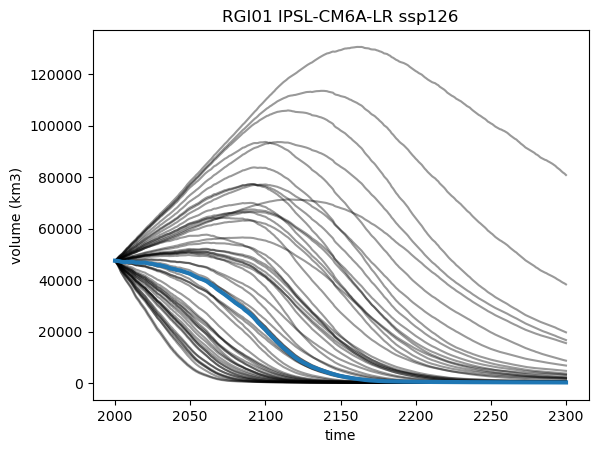

In [22]:
df_vol.plot(legend=False, color='k', alpha=0.4);
df_vol['00'].plot(c='C0', linewidth=3);
plt.title('RGI01 IPSL-CM6A-LR ssp126');
plt.ylabel('volume (km3)');

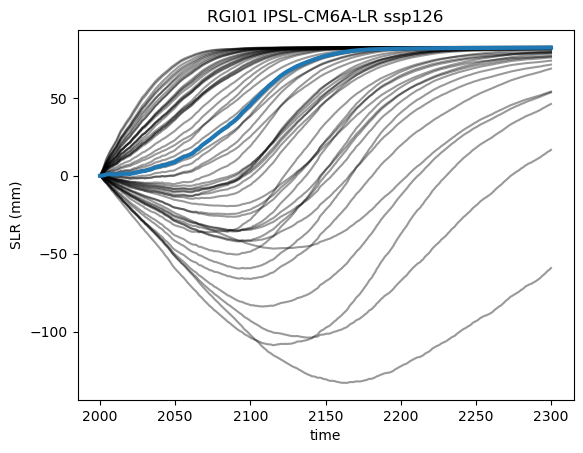

In [23]:
df_slr.plot(legend=False, color='k', alpha=0.4);
df_slr['00'].plot(c='C0', linewidth=3);
plt.title('RGI01 IPSL-CM6A-LR ssp126');
plt.ylabel('SLR (mm)');

['output_agg_upscaled/RGI01/slr_MRI-ESM2-0_ssp585.csv',
 'output_agg_upscaled/RGI02/slr_MRI-ESM2-0_ssp585.csv',
 'output_agg_upscaled/RGI03/slr_MRI-ESM2-0_ssp585.csv',
 'output_agg_upscaled/RGI04/slr_MRI-ESM2-0_ssp585.csv',
 'output_agg_upscaled/RGI05/slr_MRI-ESM2-0_ssp585.csv',
 'output_agg_upscaled/RGI06/slr_MRI-ESM2-0_ssp585.csv',
 'output_agg_upscaled/RGI07/slr_MRI-ESM2-0_ssp585.csv',
 'output_agg_upscaled/RGI08/slr_MRI-ESM2-0_ssp585.csv',
 'output_agg_upscaled/RGI09/slr_MRI-ESM2-0_ssp585.csv',
 'output_agg_upscaled/RGI10/slr_MRI-ESM2-0_ssp585.csv',
 'output_agg_upscaled/RGI11/slr_MRI-ESM2-0_ssp585.csv',
 'output_agg_upscaled/RGI12/slr_MRI-ESM2-0_ssp585.csv',
 'output_agg_upscaled/RGI13/slr_MRI-ESM2-0_ssp585.csv',
 'output_agg_upscaled/RGI14/slr_MRI-ESM2-0_ssp585.csv',
 'output_agg_upscaled/RGI15/slr_MRI-ESM2-0_ssp585.csv',
 'output_agg_upscaled/RGI16/slr_MRI-ESM2-0_ssp585.csv',
 'output_agg_upscaled/RGI17/slr_MRI-ESM2-0_ssp585.csv',
 'output_agg_upscaled/RGI18/slr_MRI-ESM2-0_ssp58

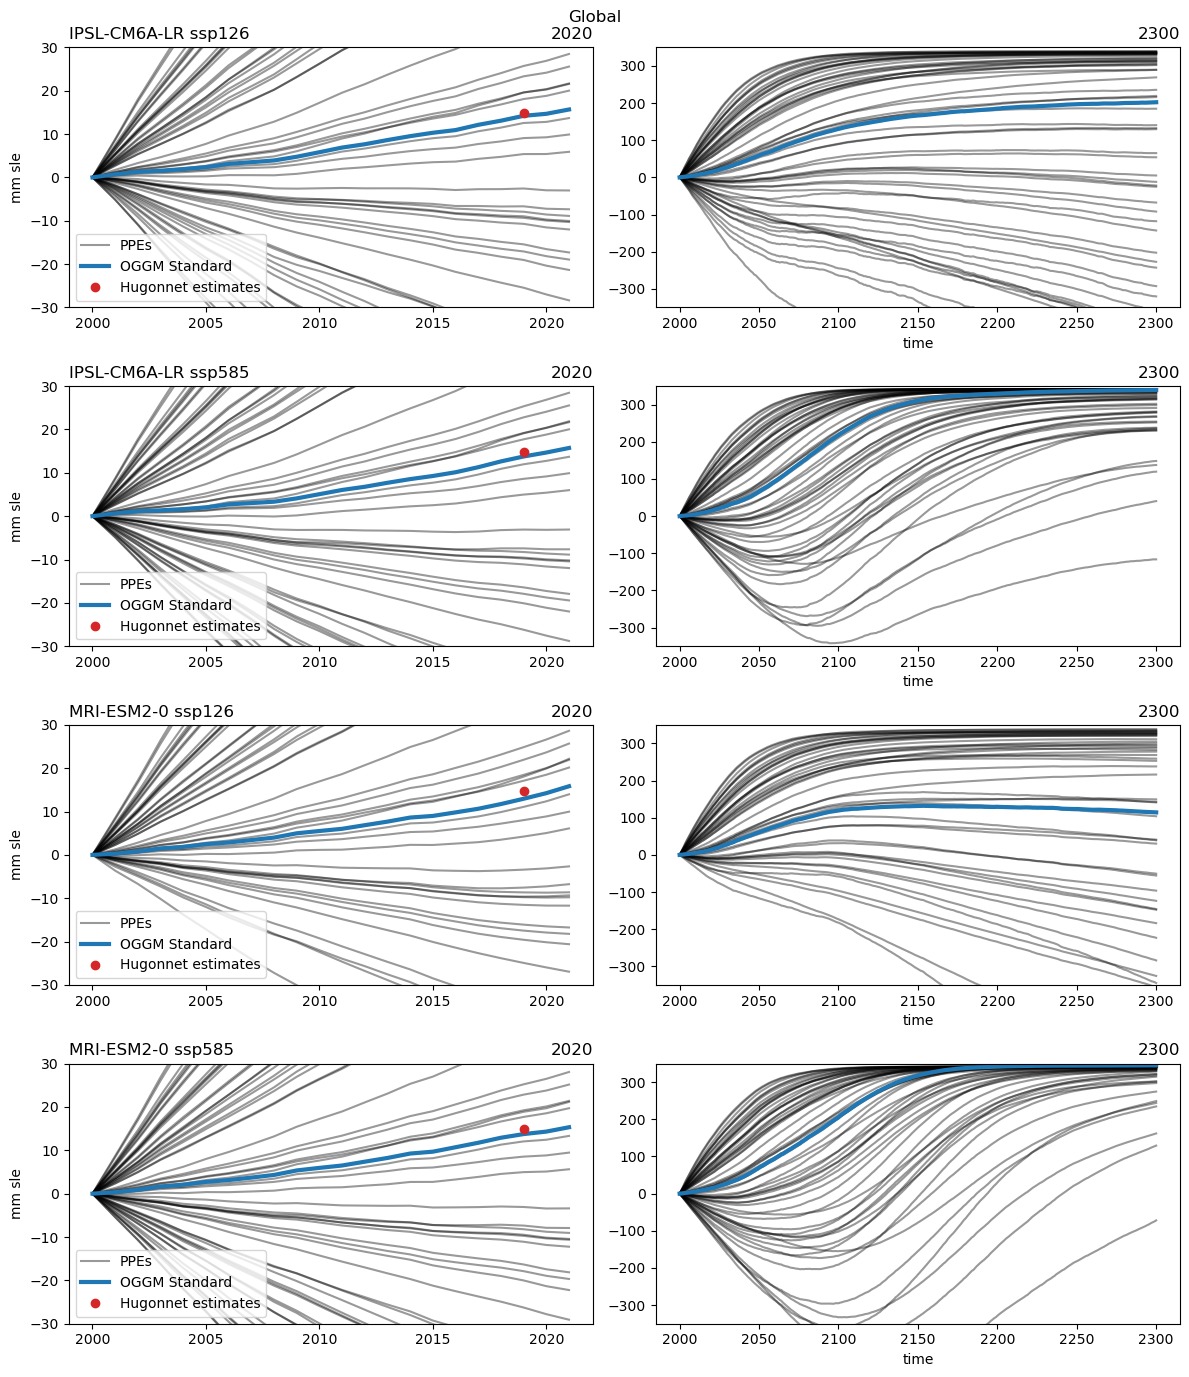

In [115]:
f, axs = plt.subplots(4, 2, figsize=(12, 14))

i = 0
for gcm in gcms:
    for ssp in ssps:
        vfiles = sorted(glob.glob(f'output_agg_upscaled/RGI*/slr_{gcm}_{ssp}.csv'))
        df_slr = 0
        for fv in vfiles:
            df_slr += pd.read_csv(fv, index_col=0)
            
        ax1, ax2 = axs[i, :]
        i += 1

        df_slr.loc[2000:2021].plot(legend=False, color='k', alpha=0.4, ax=ax1);
        df_slr.loc[2000:2021]['00'].plot(c='C0', linewidth=3, ax=ax1, label='OGGM Standard');
        ax1.plot(2019, 0.74*20, 'o', c='C3', label='Hugonnet estimates');
        handles, labels = ax1.get_legend_handles_labels()
        ax1.legend(handles=handles[-3:], labels=['PPEs'] + labels[-2:], loc='lower left')
        # ax1.errorbar(2019, 0.74*20, yerr=0.04*20, marker='o');
        ax1.set_ylim(-30, 30);
        ax1.set_xlabel('')
        ax1.set_ylabel('mm sle')

        df_slr.plot(legend=False, color='k', alpha=0.4, ax=ax2);
        df_slr['00'].plot(c='C0', linewidth=3, ax=ax2);
        ax2.set_ylim(-350, 350);
        ax2.set_ylabel('')
        ax1.set_xlabel('')
        
        ax1.set_title(f'{gcm} {ssp}', loc='left');
        ax1.set_title(f'2020', loc='right');
        ax2.set_title(f'2300', loc='right');

f.suptitle('Global')
f.tight_layout()

1.656

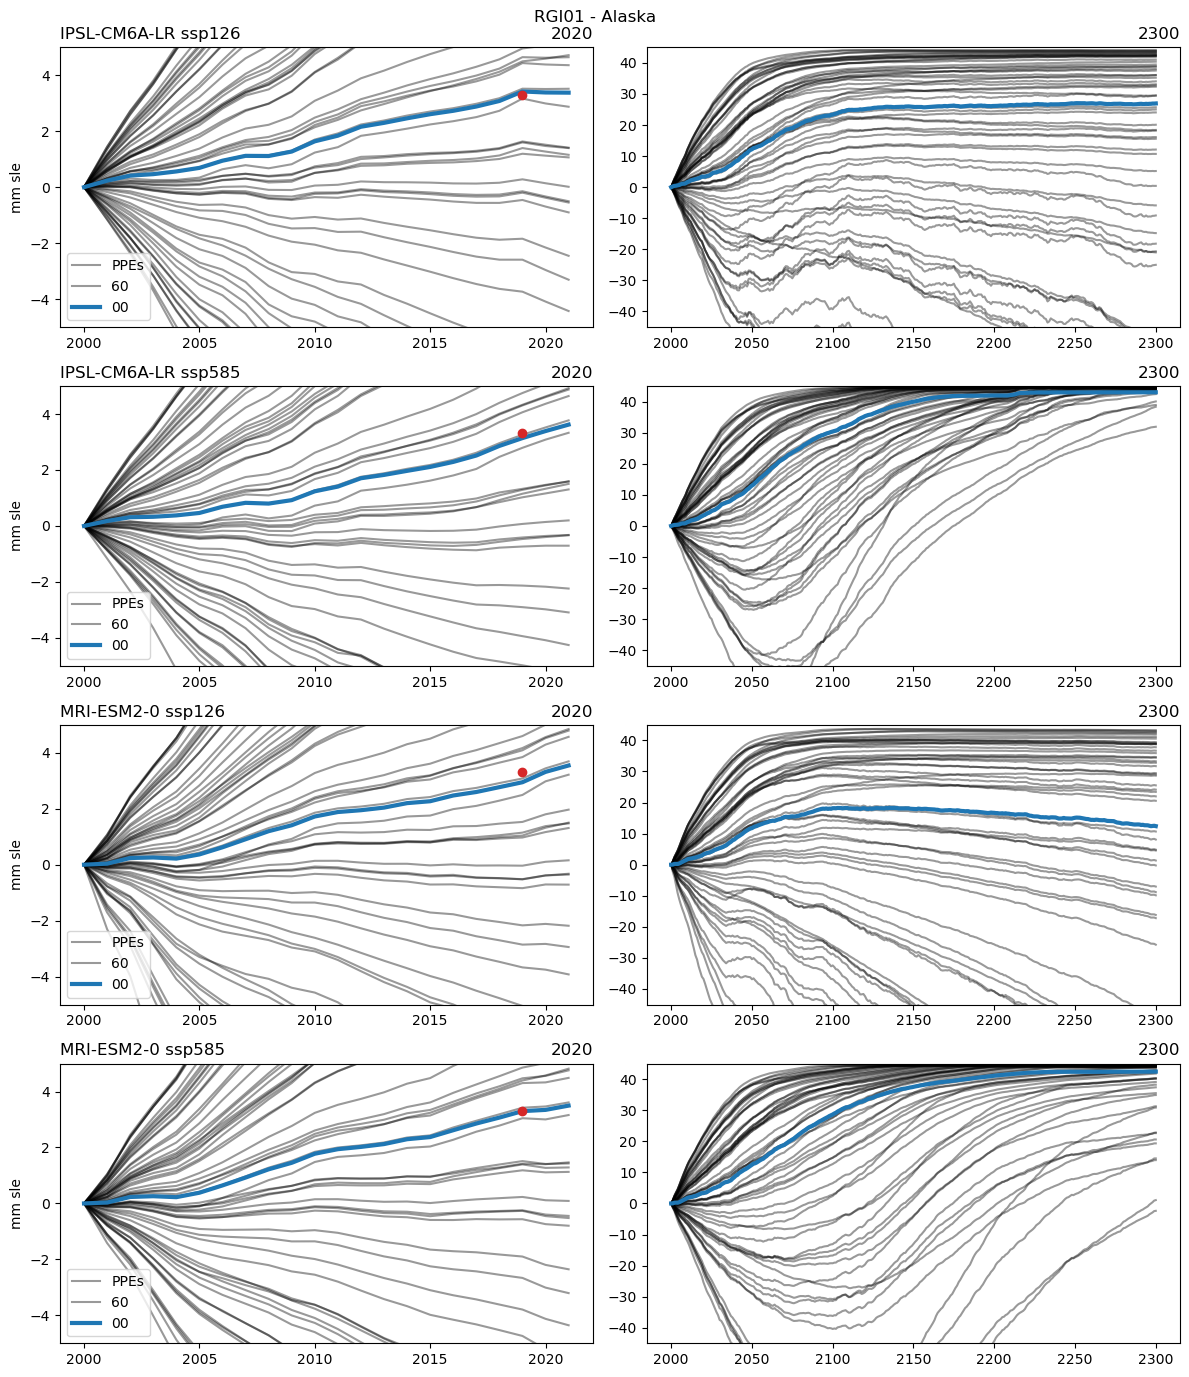

In [117]:
f, axs = plt.subplots(4, 2, figsize=(12, 14))

i = 0
for gcm in gcms:
    for ssp in ssps:
        vfiles = sorted(glob.glob(f'output_agg_upscaled/RGI01/slr_{gcm}_{ssp}.csv'))
        df_slr = 0
        for fv in vfiles:
            df_slr += pd.read_csv(fv, index_col=0)
            
        ax1, ax2 = axs[i, :]
        i += 1

        df_slr.loc[2000:2021].plot(legend=False, color='k', alpha=0.4, ax=ax1);
        df_slr.loc[2000:2021]['00'].plot(c='C0', linewidth=3, ax=ax1);
        ax1.plot(2019, 66.7 * 20 * 1e9 * (rho / rho_w) / A_oc, 'o', c='C3');
        handles, labels = ax1.get_legend_handles_labels()
        ax1.legend(handles=handles[-3:], labels=['PPEs'] + labels[-2:], loc='lower left')
        
        # ax1.errorbar(2019, 0.74*20, yerr=0.04*20, marker='o');
        ax1.set_ylim(-5, 5);
        ax1.set_xlabel('')
        ax1.set_ylabel('mm sle')
        
        handles, labels = ax1.get_legend_handles_labels()
        ax1.legend(handles=handles[-3:], labels=['PPEs'] + labels[-2:], loc='lower left')

        df_slr.plot(legend=False, color='k', alpha=0.4, ax=ax2);
        df_slr['00'].plot(c='C0', linewidth=3, ax=ax2);
        ax2.set_ylim(-45, 45);
        ax2.set_ylabel('')
        ax2.set_xlabel('')
        
        ax1.set_title(f'{gcm} {ssp}', loc='left');
        ax1.set_title(f'2020', loc='right');
        ax2.set_title(f'2300', loc='right');

f.suptitle('RGI01 - Alaska')
f.tight_layout()

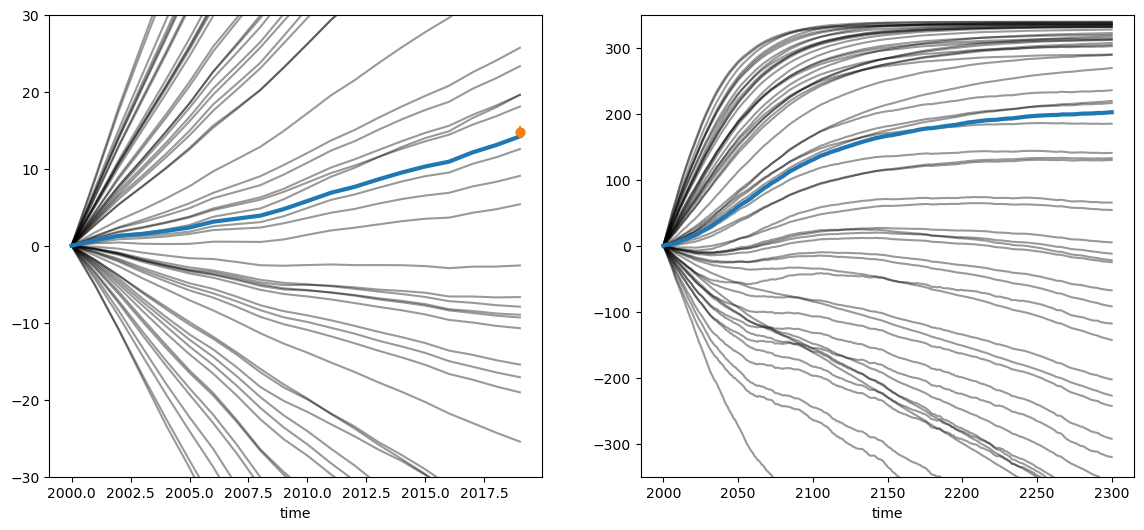

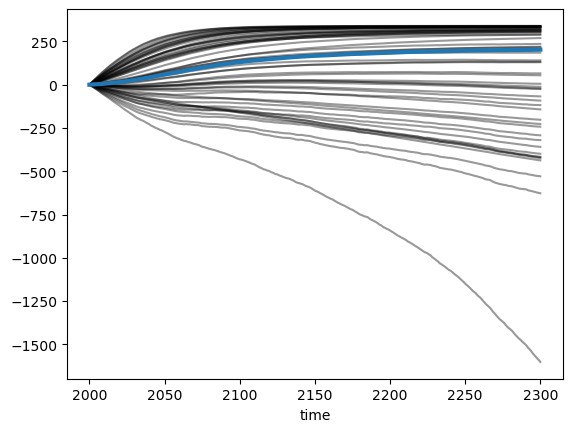

In [76]:
df_slr.plot(legend=False, color='k', alpha=0.4);
df_slr['00'].plot(c='C0', linewidth=3);

In [72]:
df_slr.max().max()

336.14108485301557

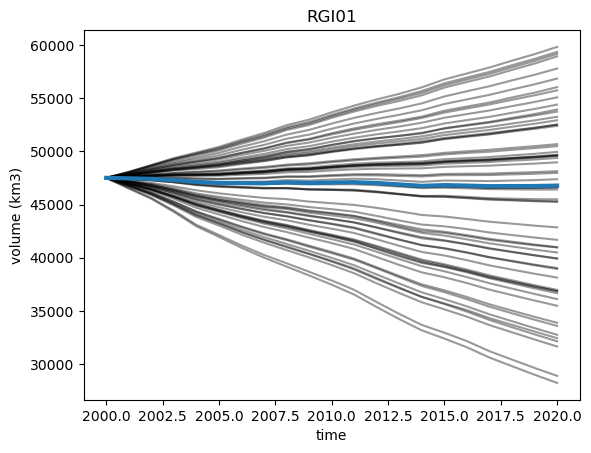

In [24]:
df_vol.loc[:2020].plot(legend=False, color='k', alpha=0.4);
df_vol.loc[:2020]['00'].plot(c='C0', linewidth=3);

plt.title('RGI01');
plt.ylabel('volume (km3)');

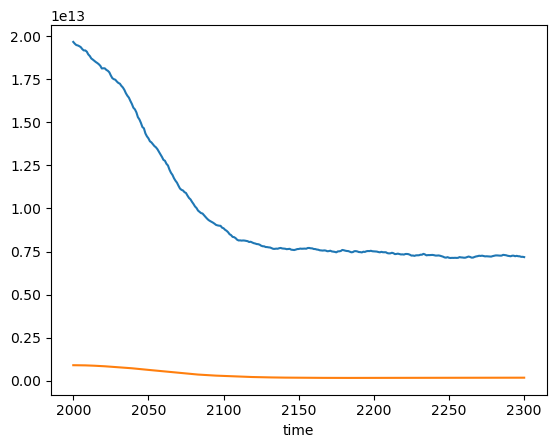

In [21]:
df.volume.plot();
df.volume_bsl.plot();

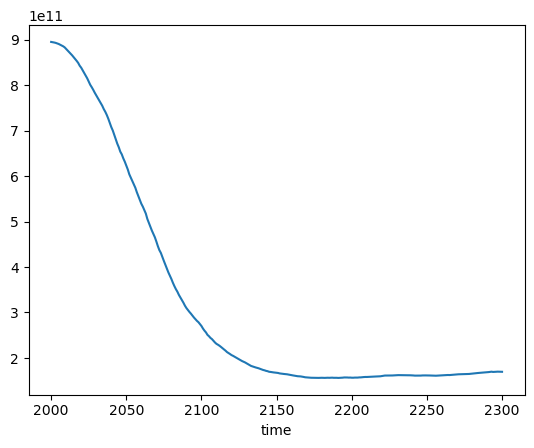

In [18]:
f'output/RGI01/IPSL-CM6A-LR/IPSL-CM6A-LR_ssp126_{exp:02d}_00_batch_*.csv'

'output/RGI01/IPSL-CM6A-LR/IPSL-CM6A-LR_ssp126_00_00_batch_*.csv'